In [73]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
                crps
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

The different sites are listed below:

In [2]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Loading the csv's

In [3]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

Let's first look at BARC which has every target series available

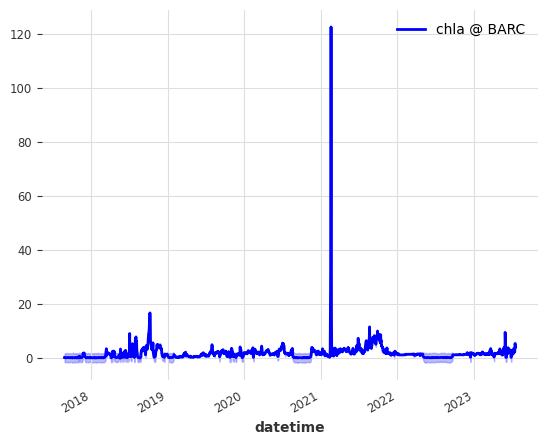

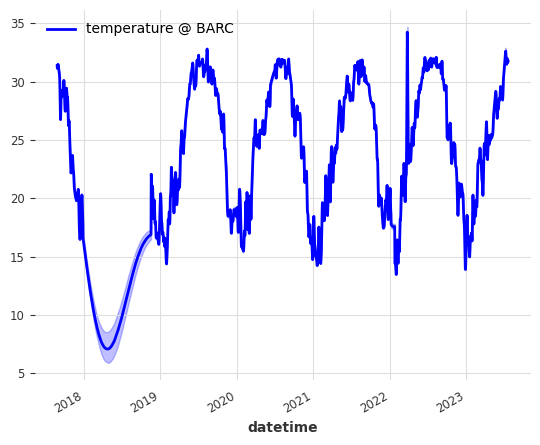

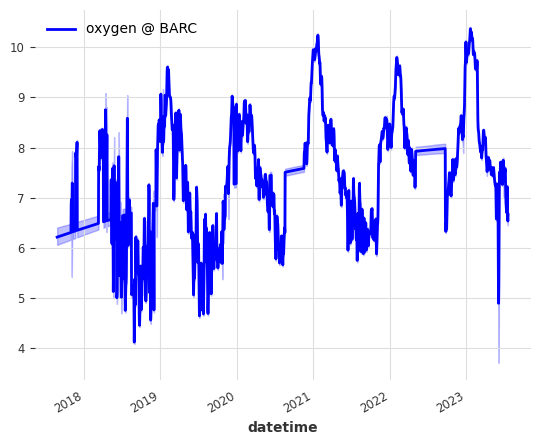

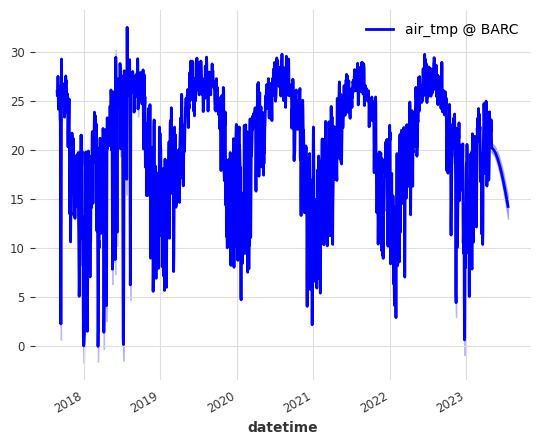

In [4]:
data_preprocessor.plot_by_site("BARC")

After running `python block_rnn.py &` and `python tcn.py &` on command line, let's look at the forecasts. Note this was for oxygen target series at BARC.

In [92]:
forecasts_dict = {}

In [93]:
def make_plot(csv_name, site, target_variable, record_dict):
    df = pd.read_csv(f"training_scripts/forecasts/{csv_name}.csv")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")
    target_series = data_preprocessor.sites_dict[site][target_variable]
    validation_series = target_series.slice(times[0], times[-1]).median()

    if site not in record_dict.keys():
        record_dict[site] = {target_variable: {csv_name: model_forecast}}
        record_dict[site][target_variable]["validation"] = validation_series
    else:
        record_dict[site][target_variable][csv_name] = model_forecast
    model_forecast.plot(color="salmon", label="Forecast")
    validation_series.plot(color="black", label="Truth")

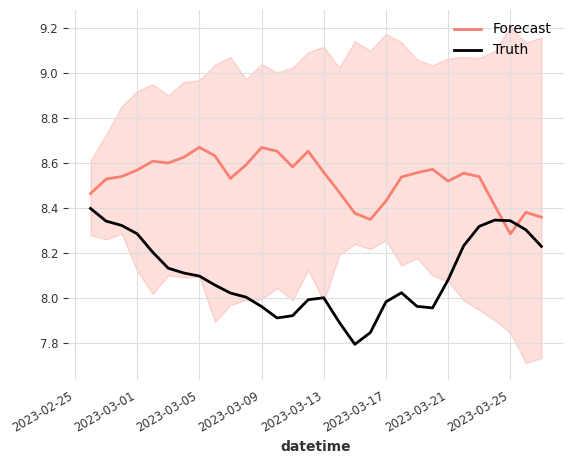

In [94]:
make_plot("block_rnn", "BARC", "oxygen", forecasts_dict)

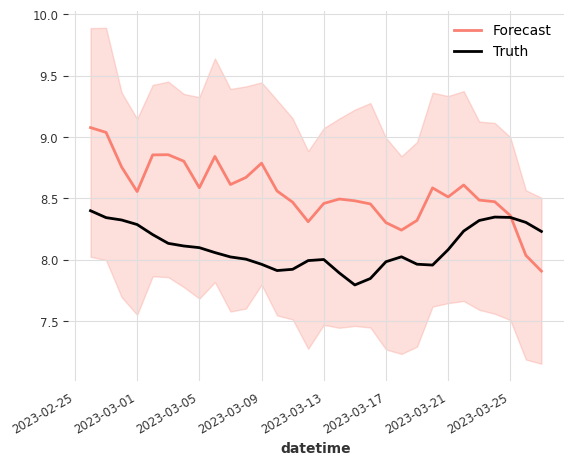

In [95]:
make_plot("tcn", "BARC", "oxygen", forecasts_dict)

Ok let's compare SMAPE and CRPS, first with CRPS.

In [96]:
block_crps = crps(forecasts_dict["BARC"]["oxygen"]["block_rnn"], forecasts_dict["BARC"]["oxygen"]["validation"])
tcn_crps = crps(forecasts_dict["BARC"]["oxygen"]["tcn"], forecasts_dict["BARC"]["oxygen"]["validation"])

Not the best plot selection here but going with it. Jitter plot in SNS way better.

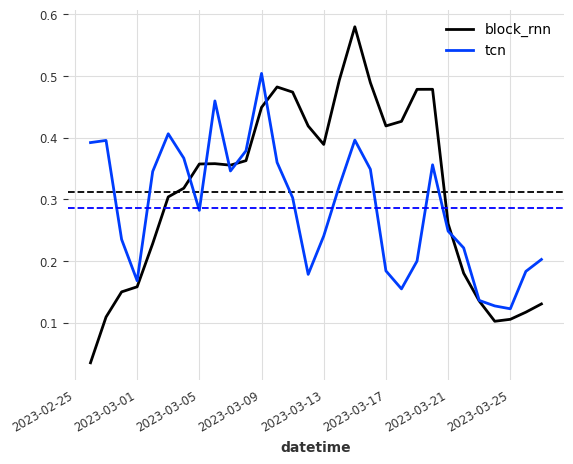

In [97]:
plt.clf()
block_crps.plot(label = "block_rnn")
plt.axhline(y = block_crps.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
tcn_crps.plot(label = "tcn")
plt.axhline(y = tcn_crps.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')
plt.show()

And, now with SMAPE

In [98]:
block_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"], 
                     n_jobs=-1, 
                     verbose=False)

tcn_smapes = smape(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     n_jobs=-1, 
                     verbose=False)

In [99]:
block_smapes, tcn_smapes

(5.18028470325917, 5.826564064041284)

And, with rho risk

In [103]:
block_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.5,
                     verbose=False)

tcn_rho_50 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.5,
                     verbose=False)

block_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.05,
                     verbose=False)

tcn_rho_05 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.05,
                     verbose=False)

block_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                     rho=0.95,
                     verbose=False)

tcn_rho_95 = rho_risk(forecasts_dict["BARC"]["oxygen"]["validation"], 
                     forecasts_dict["BARC"]["oxygen"]["tcn"], 
                     rho=0.95,
                     verbose=False)

In [104]:
block_rho_05, tcn_rho_05

(0.08126538384662846, 0.053911427992865184)

In [102]:
block_rho_50, tcn_rho_50

(0.0533452282821601, 0.04693386112683963)

In [105]:
block_rho_95, tcn_rho_95

(0.0064216792762933515, 0.006512460441479214)